In [3]:
import torch
import torch.nn as nn
import random
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm

### 1. create the dataset

In [4]:
class BalancedSparseDNADataset(Dataset):
    def __init__(self, n_samples=2000, seq_len=50, num_rules=4, seed=None):
        self.bases = ['A', 'C', 'G', 'T']
        self.base2idx = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
        self.seq_len = seq_len
        self.data = []

        if seed is not None:
            random.seed(seed)

        # Select random positions for the rule
        self.positions = sorted(random.sample(range(seq_len), num_rules))
        self.rule_description = (
            f"Even number of 'A' or 'T' in positions {self.positions}"
        )

        # Rule function
        def rule_fn(seq):
            count = sum(seq[i] in {'A', 'T'} for i in self.positions)
            return int(count % 2 == 0)
        self.rule_fn = rule_fn

        # Generate balanced dataset
        positives = []
        negatives = []
        max_each = n_samples / 2
        while len(positives) < max_each or len(negatives) < max_each:
            seq = [random.choice(self.bases) for _ in range(seq_len)]
            label = rule_fn(seq)
            if label == 1 and len(positives) < max_each:
                positives.append((seq, label))
            elif label == 0 and len(negatives) < max_each:
                negatives.append((seq, label))
        
        self.data = positives + negatives
        random.shuffle(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq, label = self.data[idx]
        encoded_seq = torch.tensor([self.base2idx[base] for base in seq], dtype=torch.long)
        label = torch.tensor(label, dtype=torch.float)
        return encoded_seq, label


### 2. implement the architectures

In [5]:
CLS_IDX = 4

def add_cls_token(x):
    cls_column = torch.full((x.size(0), 1), CLS_IDX, dtype=torch.long, device=x.device)
    return torch.cat([cls_column, x], dim=1)

In [6]:
class CustomTransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, ff_dim):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, batch_first=True)
        self.linear1 = nn.Linear(d_model, ff_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.linear2 = nn.Linear(ff_dim, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.1)
        self.attn_weights = None  # store attention weights

    def forward(self, src, src_mask=None, src_key_padding_mask=None, is_causal=None):
        attn_output, attn_weights = self.self_attn(
            src, src, src,
            attn_mask=src_mask,
            key_padding_mask=src_key_padding_mask,
            need_weights=True,
            is_causal=is_causal,
            average_attn_weights=False  # important if you want per-head weights
        )
        self.attn_weights = attn_weights  # shape: [batch_size, num_heads, seq_len, seq_len]
        src = src + self.dropout1(attn_output)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.relu((self.linear1(src)))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src


In [7]:
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, seq_len, d_model=32, nhead=2, ff_dim=64):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_embedding = nn.Parameter(torch.randn(1, seq_len + 1, d_model))
        self.encoder_layer = CustomTransformerEncoderLayer(d_model, nhead, ff_dim)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=1)
        self.classifier = nn.Sequential(
            nn.Linear(d_model , ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = add_cls_token(x)
        x = self.embedding(x) + self.pos_embedding[:, :x.size(1), :]
        x = self.transformer_encoder(x)
        cls_repr = x[:, 0, :]  # CLS token's embedding
        return self.classifier(cls_repr).squeeze(1)

    def get_attention_weights(self):
        return self.transformer_encoder.layers[0].attn_weights  # [batch, num_heads, seq_len, seq_len]


In [8]:
class FFNN(nn.Module):
    def __init__(self, vocab_size, seq_len, d_model=4, hidden_dim=3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        # self.pos_embedding = nn.Parameter(torch.randn(1, seq_len, d_model))

        self.mlp = nn.Sequential(
            nn.Linear(seq_len * d_model, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.embedding(x)  # [batch, seq_len, d_model]
        x = x.flatten(start_dim=1)  # [batch, seq_len * d_model]
        return self.mlp(x).squeeze(1)


### 3. implement training code

In [ ]:
def train_model(model, dataloader, epochs=10, lr=2e-3, debug=False):
    losses = []
    model.train()
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x, y in dataloader:
            logits = model(x)
            loss = loss_fn(logits, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        losses.append(avg_loss)
        
        if debug:
            print(f"Epoch {epoch:02d} - Loss: {avg_loss:.4f}")
    return losses



def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in dataloader:
            out = model(x)
            preds = (out>=0.5)
            correct += (preds == y).sum().item()
            total += y.size(0)

    print(f"Accuracy: {correct / total * 100:.2f}%")


In [ ]:
configs = [(50,10), (200,10)]
num_runs = 20
epochs = 3000

batch_size = 20000

transformer_all_losses = []
ffnn_all_losses = []

for (n, k) in configs:
    for _ in tqdm(range(100)):
        dna_dataset = BalancedSparseDNADataset(seq_len=n, num_rules=k)
        dna_loader = DataLoader(dna_dataset, batch_size=batch_size, shuffle=True)

        transformer = TransformerClassifier(vocab_size=5, nhead=2*k, d_model=40, seq_len=n)
        t_losses = train_model(transformer, dna_loader, epochs, lr=8e-3, debug=True)
        transformer_all_losses.append(t_losses)

        ffnn = FFNN(k, n)
        f_losses = train_model(ffnn, dna_loader, epochs, lr=2e-2, debug=True)
        ffnn_all_losses.append(f_losses)


    transformer_all_losses = torch.tensor(transformer_all_losses)
    transformer_all_losses = np.array(transformer_all_losses)

    ffnn_all_losses = torch.tensor(transformer_all_losses)
    ffnn_all_losses = np.array(transformer_all_losses)

    with open(f"../numeric_log/classification/transformer_gene_{n}_{k}.npy", "wb") as f:
        np.save(f, transformer_all_losses)

    with open(f"../numeric_log/classification/ffnn_gene_{n}_{k}.npy", "wb") as f:
        np.save(f, ffnn_all_losses)


In [18]:
import matplotlib.pyplot as plt
def init_plot_params():
        plt.rcParams['savefig.dpi'] = 600

        plt.rcParams['font.family'] = 'STIXGeneral'

        plt.rcParams['legend.fontsize'] = 35
        plt.rcParams['font.size'] = 40               # Base font size
        plt.rcParams['axes.labelsize'] = 45          # x/y label size
        plt.rcParams['legend.fontsize'] = 42         # Legend font size
        plt.rcParams['xtick.labelsize'] = 40       # Tick font size
        plt.rcParams['ytick.labelsize'] = 40

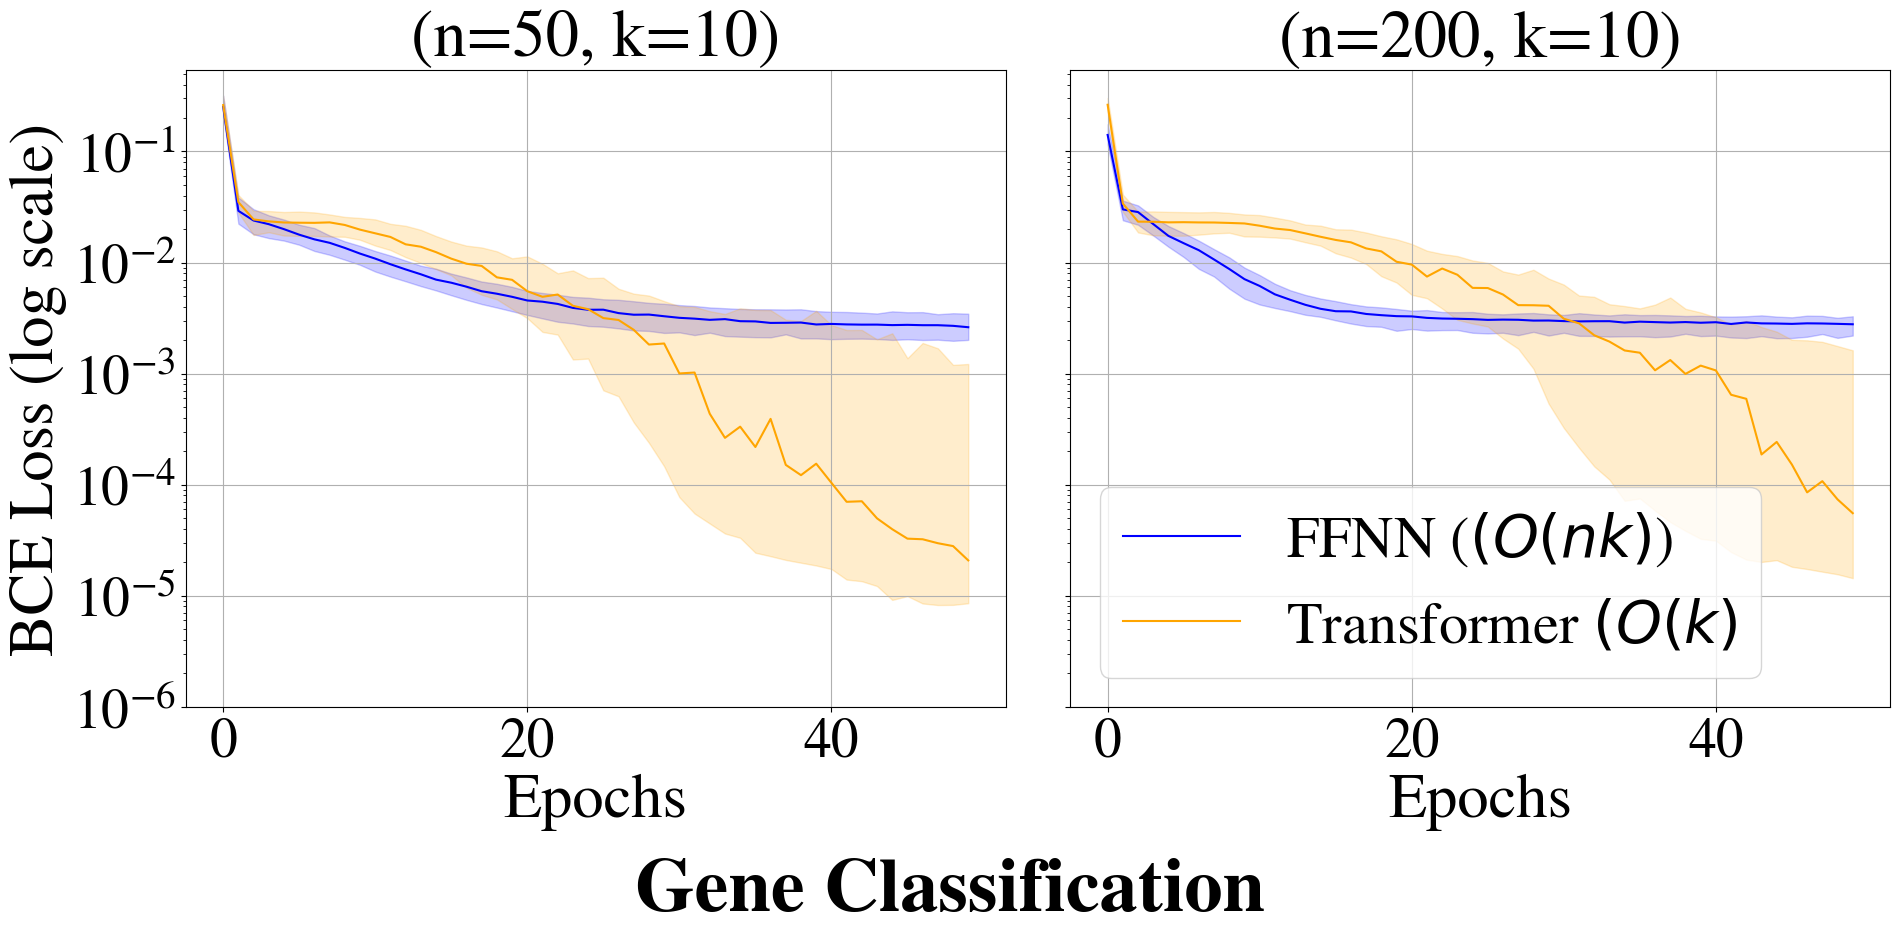

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

init_plot_params()

# === Configurations ===
configs = [
    {"n": 50, "k": 10},
    {"n": 200, "k": 10},
]

fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

for ax, cfg in zip(axes, configs):
    n, k = cfg["n"], cfg["k"]


    ffnn_losses = np.load(f"../numeric_log/classification/ffnn_gene_{n}_{k}.npy")  # [runs, epochs]
    transformer_losses = np.load(f"../numeric_log/classification/transformer_gene_{n}_{k}.npy")
    ffnn_epochs = ffnn_losses.shape[1]
    
    def get_stats(losses):
        q1 = np.percentile(losses, 25, axis=0)
        q2 = np.percentile(losses, 50, axis=0)
        q3 = np.percentile(losses, 75, axis=0)
        return q1, q2, q3

    f_q1, f_q2, f_q3 = get_stats(ffnn_losses)
    t_q1, t_q2, t_q3 = get_stats(transformer_losses)

    epochs = np.arange(ffnn_epochs)

    # Plot FFNN
    ax.plot(epochs, f_q2, label="FFNN ($(O(nk)$)", color="blue")
    ax.fill_between(epochs, f_q1, f_q3, color="blue", alpha=0.2)

    # Plot Transformer
    ax.plot(epochs, t_q2, label="Transformer $(O(k)$", color="orange")
    ax.fill_between(epochs, t_q1, t_q3, color="orange", alpha=0.2)

    ax.set_yscale("log")
    plt.ylim(bottom=1e-6)
    ax.set_xlabel("Epochs")
    ax.set_title(f"(n={n}, k={k})", fontsize=48)
    ax.grid(True)

axes[0].set_ylabel("BCE Loss (log scale)")
axes[1].legend(loc="lower left")
plt.figtext(0.5, -0.02, "Gene Classification", ha='center', fontsize=55, fontweight="bold")
plt.tight_layout()
plt.subplots_adjust(top=0.82)
plt.savefig("gene_classification.pdf", bbox_inches='tight')
plt.show()